In [1]:
import pandas as pd
import numpy as np
import matplotlib as pyplot
from datetime import datetime

In [2]:
df = pd.read_csv("april.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9433 entries, 0 to 9432
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tanggal     9433 non-null   object
 1   waktu       9433 non-null   object
 2   ketinggian  9433 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 221.2+ KB


In [3]:
#ubah menjadi datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], format='%d/%m/%Y')
df['waktu'] = pd.to_datetime(df['waktu'], format='%H:%M:%S').dt.time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9433 entries, 0 to 9432
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tanggal     9433 non-null   datetime64[ns]
 1   waktu       9433 non-null   object        
 2   ketinggian  9433 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 221.2+ KB


In [4]:
# gabung
df['waktu1'] = df.apply(lambda row: datetime.combine(row['tanggal'], row['waktu']), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9433 entries, 0 to 9432
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tanggal     9433 non-null   datetime64[ns]
 1   waktu       9433 non-null   object        
 2   ketinggian  9433 non-null   int64         
 3   waktu1      9433 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 294.9+ KB


In [5]:
# Menghapus kolom 'tanggal' dan 'waktu' yang lama
df.drop(columns=['tanggal', 'waktu'], inplace=True)
df

,ketinggian,waktu1
0,93,2023-04-01 00:00:00
1,129,2023-04-01 01:00:00
2,153,2023-04-01 02:00:00
3,160,2023-04-01 03:00:00
4,159,2023-04-01 04:00:00
...,...,...
9428,63,2024-04-30 19:00:00
9429,83,2024-04-30 20:00:00
9430,100,2024-04-30 21:00:00
9431,116,2024-04-30 22:00:00


In [6]:
#cek data hilang
df.isnull().sum()

ketinggian    0
waktu1        0
dtype: int64

<Axes: ylabel='ketinggian'>

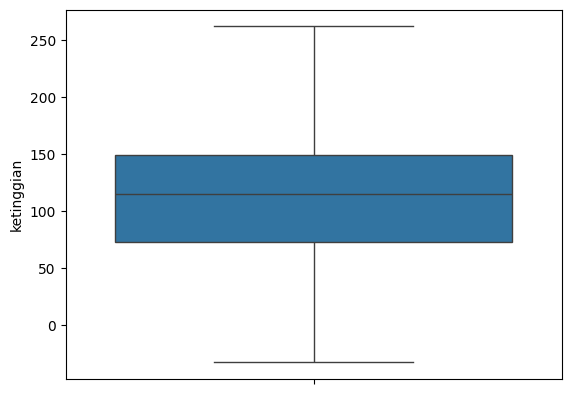

In [7]:
#cek outlier
import seaborn as sns
sns.boxplot(y=df['ketinggian'])

In [8]:
#cek data stationer atau tidak 
from statsmodels.tsa.stattools import adfuller
def adfuller_test(tinggi):
  result=adfuller(tinggi)
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
  for value,label in zip(result,labels):
    print(label+' : '+str(value) )
  if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho),Data is stationary")
  else:
    print("weak evidence against null hypothesis,indicating it is non- stationary ")
adfuller_test(df['ketinggian'])

ADF Test Statistic : -3.398124521210949
p-value : 0.011022972945383866
#Lags Used : 38
Number of Observations : 9394
strong evidence against the null hypothesis(Ho),Data is stationary


In [9]:
# hitung data training dengan data testing
utrain = int(len(df) * 0.8)
utest = len(df) - utrain
utrain

7546

In [10]:
# pisah data training dan data testing
train = df.iloc[:7546]
test = df.iloc[7546:]
train

,ketinggian,waktu1
0,93,2023-04-01 00:00:00
1,129,2023-04-01 01:00:00
2,153,2023-04-01 02:00:00
3,160,2023-04-01 03:00:00
4,159,2023-04-01 04:00:00
...,...,...
7541,118,2024-02-12 04:00:00
7542,151,2024-02-12 05:00:00
7543,150,2024-02-12 06:00:00
7544,144,2024-02-12 07:00:00


In [11]:
def create_dataset(dataset, look_back=1):
    # Ensure dataset is a numpy array
    dataset = np.asarray(df)
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 1
trainX, trainY = create_dataset(train[['ketinggian']], look_back)
testX, testY = create_dataset(test[['ketinggian']], look_back)

In [13]:
# menghilangkan data yang lebih dari data testing 
if len(testX) < len(test):
    # Padding with zeros or some other value to match the length
    padding_size = len(test) - len(testX)
    testX = np.vstack([testX, np.zeros((padding_size, look_back))])
    testY = np.concatenate([testY, np.zeros(padding_size)])

# Or if you want to remove extra data from testX and testY
if len(testX) > len(test):
    testX = testX[:len(test)]
    testY = testY[:len(test)]

In [14]:
if len(trainX) > len(train) - look_back:
    # Jika trainX lebih panjang, potong menjadi sesuai dengan panjang train
    trainX = trainX[:len(train) - look_back]
    trainY = trainY[:len(train) - look_back]
    
elif len(trainX) < len(train) - look_back:
    # Jika trainX lebih pendek, tambahkan padding dengan nol
    padding_size = (len(train) - look_back) - len(trainX)
    
    # Sesuaikan padding dengan dimensi `trainX`
    padding_X = np.zeros((padding_size, trainX.shape[1])) if trainX.ndim == 2 else np.zeros((padding_size, trainX.shape[1], trainX.shape[2]))
    trainX = np.vstack([trainX, padding_X])
    
    # Padding untuk `trainY`, yang merupakan array 1D
    padding_Y = np.zeros(padding_size)
    trainY = np.concatenate([trainY, padding_Y])

In [15]:
len(trainX)

7545

In [16]:
# Normalisasi data
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

trainX = scaler_X.fit_transform(trainX)
testX = scaler_X.transform(testX)

trainY = scaler_Y.fit_transform(trainY.reshape(-1, 1))
testY = scaler_Y.transform(testY.reshape(-1, 1))

In [17]:
# Ubah data menjadi [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [18]:
# Membuat model LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2024-09-03 16:10:11.817012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 16:10:11.817080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 16:10:11.817107: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 16:10:11.826291: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 16:10:13.699503: E tensor

In [ ]:
# Melatih model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
7545/7545 - 8s - loss: 0.0070 - 8s/epoch - 1ms/step
Epoch 2/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 934us/step
Epoch 3/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 920us/step
Epoch 4/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 927us/step
Epoch 5/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 926us/step
Epoch 6/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 934us/step
Epoch 7/100
7545/7545 - 7s - loss: 0.0048 - 7s/epoch - 927us/step
Epoch 8/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 925us/step
Epoch 9/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 923us/step
Epoch 10/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 921us/step
Epoch 11/100
7545/7545 - 7s - loss: 0.0049 - 7s/epoch - 941us/step
Epoch 12/100
7545/7545 - 7s - loss: 0.0048 - 7s/epoch - 931us/step
Epoch 13/100
7545/7545 - 7s - loss: 0.0048 - 7s/epoch - 937us/step
Epoch 14/100
7545/7545 - 7s - loss: 0.0048 - 7s/epoch - 935us/step
Epoch 15/100
7545/7545 - 7s - loss: 0.0048 - 7s/epoch - 933us/step
Epoch 

In [ ]:
# Prediksi menggunakan data pengujian

testPredict = model.predict(testX)

In [ ]:
testPredict

In [ ]:
# Mengubah bentuk data menjadi 2D array
trainY = trainY.reshape(-1, 1)
testY = testY.reshape(-1, 1)

In [ ]:
#menghitung mae, mse, dan rmse

from sklearn import metrics
mae = metrics.mean_absolute_error(testY, testPredict)
mse = metrics.mean_squared_error(testY, testPredict)
rmse = np.sqrt(mse)

In [ ]:
print (mae)
print (mse)
print (rmse)

In [ ]:
import matplotlib.pyplot as plt

# Reversi normalisasi
trainY = scaler_Y.inverse_transform(trainY)
testY = scaler_Y.inverse_transform(testY)
testPredict = scaler_Y.inverse_transform(testPredict)

# Mengatur waktu (index) untuk plot
train_len = len(trainX)
test_len = len(testX)
train_index = np.arange(0, train_len)
test_index = np.arange(train_len, train_len + test_len)

# Membuat plot
plt.figure(figsize=(14, 7))

# Plot data pelatihan
plt.plot(train_index, trainY, label='Data Pelatihan', color='blue')

# Plot data pengujian
plt.plot(test_index, testY, label='Data Pengujian', color='green')

# Plot hasil prediksi
plt.plot(test_index, testPredict, label='Hasil Prediksi', color='yellow')

# Menambahkan judul dan label
plt.title('Grafik Data Pelatihan, Data Pengujian, dan Hasil Prediksi')
plt.xlabel('Waktu')
plt.ylabel('Ketinggian')
plt.legend()
plt.show()

In [ ]:
prediksi = pd.DataFrame(testPredict, index=test_index)
trains = pd.DataFrame(trainY, index=train_index)
tests = pd.DataFrame(testY, index=test_index)

In [ ]:
gabungan = pd.concat([trains, prediksi, tests, df['waktu1']], axis=1)
gabungan.columns = ['Train', 'Prediksi', 'Test', 'Waktu']

In [ ]:
gabungan

In [ ]:
gabungan.to_csv('lstm_tableau.csv', index=False)